# K-Anonymity 
<p align="justify">$\qquad$ <b>k-anonymity</b> -модель, которая позволяет снижать риски повторной идентификации путем объединения атрибутов в группы, описывающие не менее $k$ людей. Предположим, что имеется набор из  $N$ строк/записей. Каждая запись состоит из  $D$ полей/атрибутов, из которых $X_i$ ($i \in [0,D]$) не содержат конфиденциальной информации (non-sensitive) о физическом лице, примером таких атрибутов является возраст, пол, почтовый код и т.п. Однако,  это подмножество атрибутов может в совокупности указывать на конкретное лицо в данной группе.Такие атрибуты, в совокупности указывающие на конкретную персону называются <b>квази-идентификаторами</b> ("quasi-identifiers"), а их комбинация - <b>супер-идентификатор</b> ("super-identifier"), который может указывать на уникальную персону в достаточно большом наборе данных (т.е. комбинация пола, возраста и почтового кода ведет к выделению отдельной личности). </p>


In [1]:
import pandas as pd
from collections import Counter
from openpyxl import Workbook
import numpy as np
table_name = "marketing_case_v.0.5.4.xlsx"
df = pd.read_excel(table_name, sheet_name="A1", engine = 'openpyxl')
df.tail(10)


,Локальное время покупок,Широта,Долгота,Общая сумма покупок,Код региона,Часовой пояс,Кол-во товаров в покупоке,Бренды,Категория
499990,2022-01-10T06:04,29.421,59.631,2347065,38,UTC+5,9,NEC,Монитор
499991,2022-01-09T05:58,29.424,59.621,14652,38,UTC+5,2,Allied Telesis,Коммутаторы
499992,2022-01-08T15:10,29.427,59.620,27876,38,UTC+5,4,Philips,Монитор
499993,2022-01-03T09:42,29.424,59.621,2838168,38,UTC+5,4,Supermicro,Серверы
499994,2022-01-12T05:13,29.420,59.621,4530,38,UTC+5,3,ExeGate,Корпуса
499995,2022-01-17T05:58,29.425,59.623,20064,38,UTC+5,6,Allied Telesis,Коммутаторы
499996,2022-01-06T01:33,29.420,59.622,1073085,38,UTC+5,5,NETGEAR,NAS сервера
499997,2022-01-24T03:22,29.422,59.626,241605,38,UTC+5,5,Dell,Ноутбуки
499998,2022-01-22T18:34,29.427,59.625,277123,38,UTC+5,7,Asus,Ноутбуки
499999,2022-01-14T10:26,29.421,59.601,214500,38,UTC+5,1,LG,Монитор


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 9 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Локальное время покупок     500000 non-null  object 
 1   Широта                      500000 non-null  float64
 2   Долгота                     500000 non-null  float64
 3   Общая сумма покупок         500000 non-null  int64  
 4   Код региона                 500000 non-null  int64  
 5   Часовой пояс                500000 non-null  object 
 6   Кол-во  товаров в покупоке  500000 non-null  int64  
 7   Бренды                      499778 non-null  object 
 8   Категория                   500000 non-null  object 
dtypes: float64(2), int64(3), object(4)
memory usage: 34.3+ MB


Currently each row is unique

In [3]:
'Duplicates == ' + str(df.shape[0] - df.drop_duplicates().shape[0])

'Duplicates == 0'

#### Модель $k$-anonimity и риски повторной идентификации

<p align="justify">$\qquad$ В дополнение подразумевается, что кроме квази-идентификаторов набор данных может содержать некоторые данные напрямую указывающие на личность (например, ИНН) - <b>прямые идентификаторы</b> ("direct-identificatotrs"), а также по крайней мере один атрибут представляющий чувствительную информацию - например, уровень дохода ("income") или сведения о болезни. Модель нацелена на защиту этой чувствительной информации. В рамках такой защиты записи подвергаются методам обезличивания - <b>обобщению</b> ("generalization") или подавлению ("suppression"), цель этих методов разрушить информацию таким образом, чтобы снизить количество строк с одинаковыми квази-атрибутами (так называемые классы эквивалентности). Объем минимального класса эквивалентности (количество записей с одинаковыми занчениями квази-идентификаторов) обратно пропорционален вероятности риска повторной идентификации и может служить числовой характеристикой метода.</p>


<p align="justify">$\qquad$ Применение методов обезличивания ведет к тому, что полезная информация в обезличенных наборах данных становится менеее качественной - для измерения уровня этого качества используются специальные метрики <b>расчета полезности</b> ("utility"). Суть модели - нахождение баланса между риском повторной идентификации с одной стороны и полезностью набора  данных - с другой.</p>

<p align="justify">$\qquad$ В первом приближении модель k-anonymity  требует выделения квази-идентификаторов ("QID") и вычисления для них <b>размеров классов-эквивалентности</b>  $k$ строк/физических лиц, затем итерационное применение методов обезличивания (включающих подавление строк или ячеек, обобщение значений), между которыми следует анализ получившегося набора и уточнение параметров методов обезличивания. В результате это защищает отдельных людей, сводя к минимому информацию об отдельном человеке, оставляя злоумышленнику ("adversary") только информацию о принадлежности данного человека к определенной группе.  Хотя получающийся набор не является точным, он все еще годится для целей анализа и построения моделей машинного обучения. В ряде случаев надо решать не только проблему обезличивания, но и иного подхода к идентификации, например, для решения задач, в которых обобщенные данные не могут использоваться напрямую.</p>


In [4]:
QI = ['Локальное время покупок',
    'Код региона',
    'Бренды',
    'Категория']

In [5]:
def k_anonymous(data, columns):
  ## Возьмите фрейм данных, верните значение k-anonymity
  ## Агрегируйте по именам столбцов и возьмите ненулевой минимум каждой строки
  aggregrate = data.groupby(columns).count().apply(lambda x : set(x) - set({0}),axis = 1)
  aggregrate = aggregrate.apply(lambda x : 0 if x == set() else min(x))
  return sorted(set(aggregrate))[:5]
k_anonymous = k_anonymous(df, QI)
print(' k-anonymity = ' + str(k_anonymous))

 k-anonymity = [1, 2, 3, 4, 5]


#### Количество уникальных строк

In [6]:
unique_rows = df[QI].drop_duplicates()
unique_rows.to_excel("uniques_row.xlsx")
print(f"Количество уникальных строк = {len(unique_rows)}")

Количество уникальных строк = 442241


In [7]:
print(unique_rows)

       Локальное время покупок  Код региона          Бренды  \
0             2022-01-22T04:08           38           TITAN   
1             2022-01-15T19:45           38           Crown   
2             2022-01-29T02:41           38             APC   
3             2022-01-29T14:04           38           Sharp   
4             2022-01-25T08:02           38       InterStep   
...                        ...          ...             ...   
499994        2022-01-12T05:13           38         ExeGate   
499995        2022-01-17T05:58           38  Allied Telesis   
499996        2022-01-06T01:33           38         NETGEAR   
499997        2022-01-24T03:22           38            Dell   
499998        2022-01-22T18:34           38            Asus   

                     Категория  
0           Системы охлаждения  
1          Сумки для ноутбуков  
2       Powerbank аккумуляторы  
3                      Монитор  
4       Powerbank аккумуляторы  
...                        ...  
499994      

#### Графики подсчета этих типов данных показаны ниже.

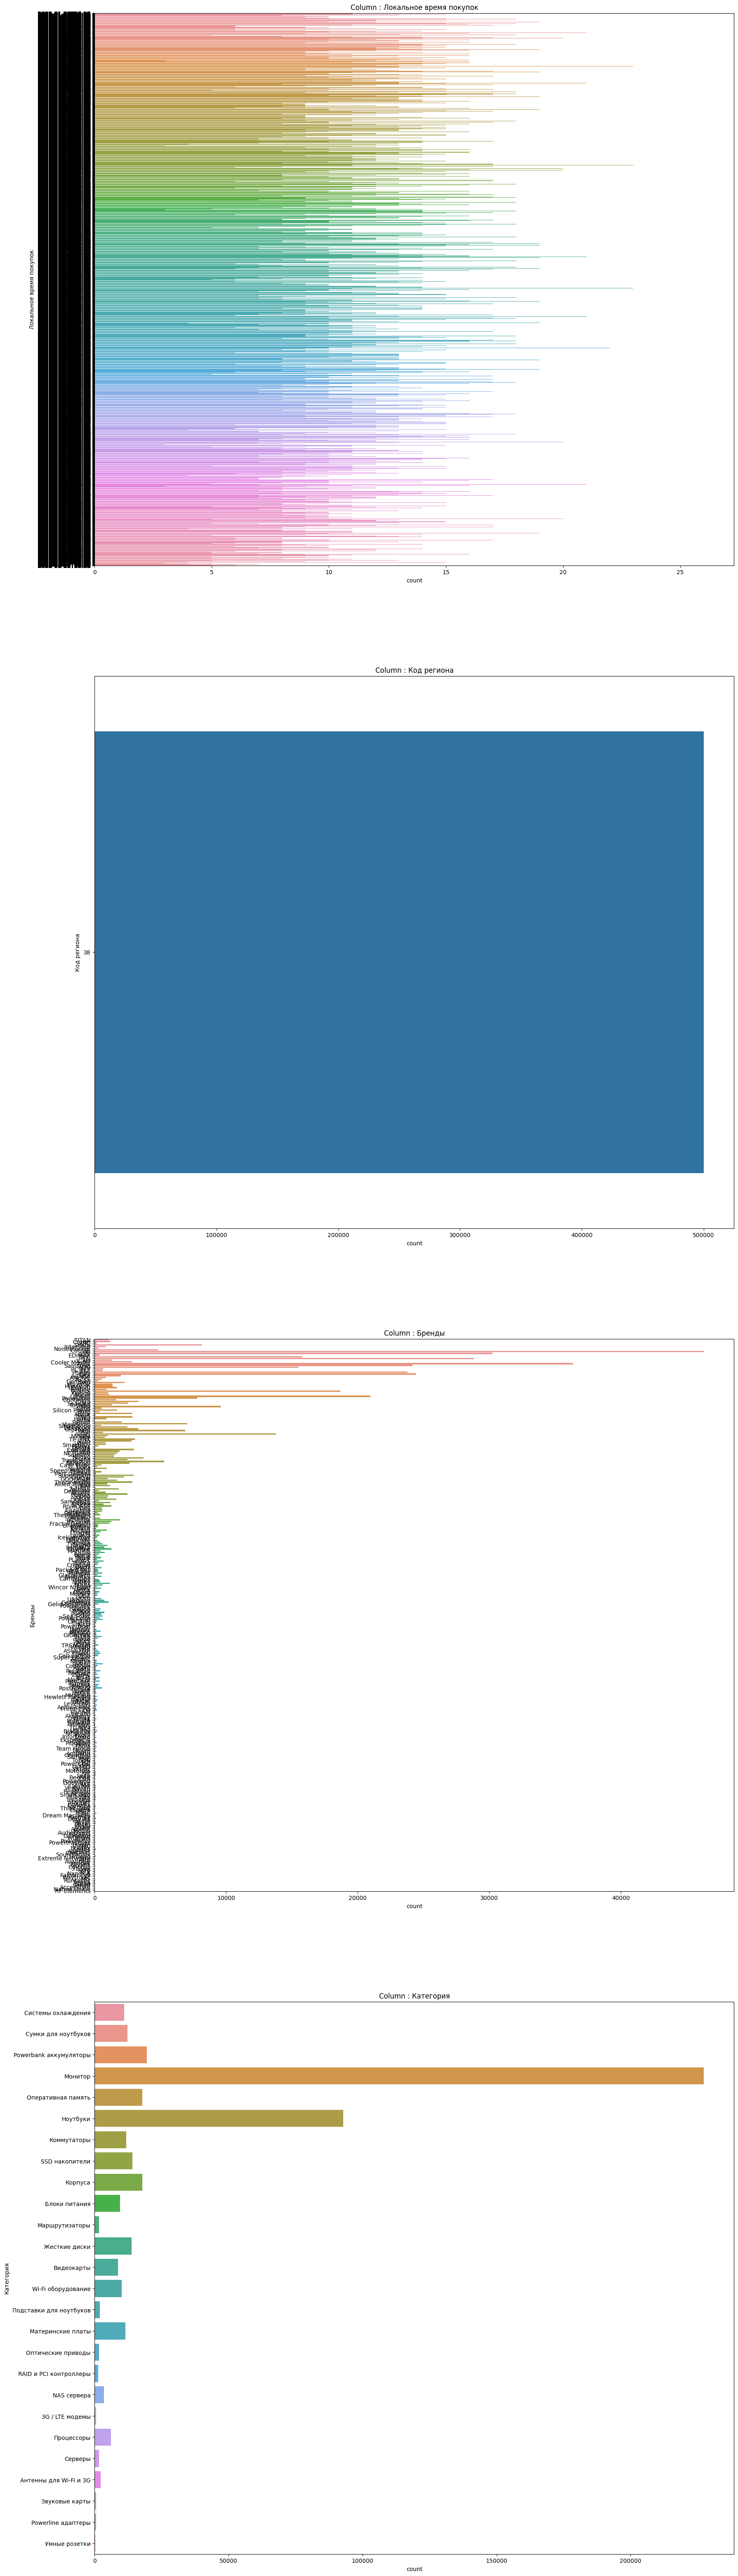

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

columns = QI

fig, ax = plt.subplots(len(columns), figsize = (20,80))
for i in range(len(columns)):
  ax[i].set_title('Column : ' + str(columns[i]))
  sns.countplot(y = columns[i], data = df, ax = ax[i])

#### Количество повторных значений

In [9]:
def quantity_qi(arg):
    quantity = Counter(df[arg])
    dic_quan = dict(quantity)
    for idx, item in enumerate(dic_quan.items(),1):
        if(arg == 'Локальное время покупок'):
            ws['A' + str(idx + 1)] = f"{item[0]}=>{item[1]}"
            ws['A1'] = f"{arg}"
        elif(arg == 'Общая сумма покупок'):
            ws['B' + str(idx + 1)] = f"{item[0]}=>{item[1]}"
            ws['B1'] = f"{arg}"
        elif(arg == 'Код региона'):
            ws['C' + str(idx + 1)] = f"{item[0]}=>{item[1]}"
            ws['C1'] = f"{arg}"
        elif(arg == 'Бренды'):
            ws['D' + str(idx +1)] = f"{item[0]}=>{item[1]}"
            ws['D1'] = f"{arg}"
        elif(arg == 'Категория'):
            ws['E' + str(idx + 1)] = f"{item[0]}=>{item[1]}"
            ws['E1'] = f"{arg}"

 #### Создается Excel файл, где в каждой ячейке после стрелочки выводиться количество повторов “имени” ячейки в исходном датасете.

In [10]:
wb = Workbook()
ws = wb.create_sheet("A1")
del wb['Sheet']
for arg in QI:
    quantity_qi(arg)
wb.save('quantity.xlsx')
df2 = pd.read_excel('quantity.xlsx', sheet_name="A1", engine = 'openpyxl')
df2.head(10)

,Локальное время покупок,Unnamed: 1,Код региона,Бренды,Категория
0,2022-01-22T04:08=>11,NaN,38=>500000,TITAN=>1060,Системы охлаждения=>10978
1,2022-01-15T19:45=>10,NaN,NaN,Crown=>1186,Сумки для ноутбуков=>12326
2,2022-01-29T02:41=>18,NaN,NaN,APC=>146,Powerbank аккумуляторы=>19424
3,2022-01-29T14:04=>15,NaN,NaN,Sharp=>8156,Монитор=>227309
4,2022-01-25T08:02=>8,NaN,NaN,InterStep=>825,Оперативная память=>17763
5,2022-01-11T20:04=>12,NaN,NaN,Noiseblocker=>304,Ноутбуки=>92752
6,2022-01-12T21:09=>17,NaN,NaN,Corsair=>4812,Коммутаторы=>11758
7,2022-01-28T09:07=>9,NaN,NaN,HP=>46284,SSD накопители=>14082
8,2022-01-29T01:54=>11,NaN,NaN,Acer=>30239,Корпуса=>17861
9,2022-01-25T02:18=>12,NaN,NaN,EDIMAX=>352,Блоки питания=>9525
